# Quantum gradients with backpropagation [[Link]](https://pennylane.ai/qml/demos/tutorial_backprop.html)

In PennyLane, any quantum device, whether a hardware device or a simulator, can be trained using the [parameter-shift rule](https://pennylane.ai/qml/glossary/parameter_shift.html) to compute quantum gradients.

Indeed, the parameter-shift rule is ideally suited to hardware devices, as it does not require any knowledge about the internal workings of the device; 
it is sufficient to treat the device as a 'black box', and to query it with different input values in order to determine the gradient.

However, in real, we do have access to the internal (classical) computations being performed. <br>
This allows us to take advantage of other methods of computing the gradient, such as backpropagation, which may be advantageous in certain regimes. 

In this tutorial, we will compare and contrast the parameter-shift rule against backpropagation, using the PennyLane `default.qubit` device.

## The parameter-shift rule
---

The parameter-shift rule states that, given a variational quantum circuit $U(\boldsymbol{\theta})$ composed of parameterized Pauli rotations, and some measured observable $\hat{B}$, <br>
the derivative of the expectation value $\langle\hat{B}\rangle(\boldsymbol{\theta}) = \langle 0|U(\boldsymbol{\theta})^\dagger\hat{B}U(\boldsymbol{\theta})|0\rangle$ w.r.t. the input circuit parameters $\theta$ is given by
$$
\nabla_{\theta_i}\langle\hat{B}\rangle(\boldsymbol{\theta}) 
= \frac{1}{2}\left[\langle\hat{B}\rangle\left(\boldsymbol{\theta}+\frac{\pi}{2}\hat{\mathbf{e}}_i\right)-\langle\hat{B}\rangle\left(\boldsymbol{\theta}-\frac{\pi}{2}\hat{\mathbf{e}}_i\right)\right].
$$
Thus, the gradient of the expectation value can be calculated by evaluating the same variational quantum circuit, but with shifted parameter values (hence the name, parameter-shift rule!).

Let us have a go implementing the parameter-shift ulre manually in PennyLane.

In [1]:
import pennylane as qml
from pennylane import numpy as np

In [2]:
# set the random seed
np.random.seed(42)

### 1-1. Create an arbitrary circuit $U(\mathbf{\theta})$

In [3]:
# create a device to execute the circuit on
dev = qml.device("default.qubit", wires=3)

@qml.qnode(dev, diff_method="parameter-shift")
def circuit(params):
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=1)
    qml.RZ(params[2], wires=2)

    qml.broadcast(qml.CNOT, wires=[0, 1, 2], pattern="ring")

    qml.RX(params[3], wires=0)
    qml.RY(params[4], wires=1)
    qml.RZ(params[5], wires=2)

    qml.broadcast(qml.CNOT, wires=[0, 1, 2], pattern="ring")
    return qml.expval(qml.PauliY(0) @ qml.PauliZ(2))

Let us test the variational circuit evaluation with some parameter input:

In [4]:
# initial parameters
params = np.random.random([6])

print("Parameters:", params)
print("Expectation value:", circuit(params))

Parameters: [0.37454012 0.95071431 0.73199394 0.59865848 0.15601864 0.15599452]
Expectation value: -0.11971365706871569


Picture of the excuted quantum circuit:

In [5]:
print(circuit.draw())

 0: ──RX(0.375)──╭C─────────────────╭X──RX(0.599)──╭C──────╭X──╭┤ ⟨Y ⊗ Z⟩ 
 1: ──RY(0.951)──╰X──╭C──RY(0.156)──│──────────────╰X──╭C──│───│┤         
 2: ──RZ(0.732)──────╰X─────────────╰C──RZ(0.156)──────╰X──╰C──╰┤ ⟨Y ⊗ Z⟩ 



### 1-2. Compute the `parameter_shift` gradient

Now that we have defined our variational circuit QNode, we can construct a function that computes the gradient of the $i$th parameter using the parameter-shift rule.

In [6]:
def parameter_shift_term(qnode, params, i): #ith parameter
    shifted = params.copy()
    shifted[i] += np.pi/2
    forward = qnode(shifted)  # forward evaluation

    shifted[i] -= np.pi
    backward = qnode(shifted) # backward evaluation

    return 0.5 * (forward - backward)

In [7]:
# gradient with respect to the first parameter
print(parameter_shift_term(circuit, params, 0))

-0.06518877224958117


In order to compute the gradient w.r.t. *all* parameters, we need to loop over the index `i`:

In [8]:
def parameter_shift(qnode, params):
    gradients = np.zeros([len(params)])

    for i in range(len(params)):
        gradients[i] = parameter_shift_term(qnode, params, i)

    return gradients

print(parameter_shift(circuit, params))

[-6.51887722e-02 -2.72891905e-02  0.00000000e+00 -9.33934621e-02
 -7.61067572e-01  8.32667268e-17]


We can compare this to PennyLane's *built-in* parameter-shift feature by using the `qml.grad` function. 
Remember, when we defined the QNode, we specified that we wanted it to be differentiable using the parameter-shift method (`diff_method="parameter-shift"`).

In [9]:
grad_function = qml.grad(circuit)
print(grad_function(params))

[-6.51887722e-02 -2.72891905e-02  0.00000000e+00 -9.33934621e-02
 -7.61067572e-01  8.32667268e-17]


If you count the number of quantum evaluations, you will notice that <br>
we had to evaluate the circuit `2*len(params)` number of times in order to compute the quantum gradient w.r.t. all parameters. 

While reasonably fast for a small number of parameters, <br>
as the number of parameters in our quantum circuit grows, so does both
1. the circuit depth (and thus the time taken to evaluate each expectation value or 'forward' pass)
2. the number of parameter-shift evaluations required.

Both of these factors increase the time taken to compute the gradient with respect to all parameters.

### 1-3. Benchmarking: Forward pass and Gradient of the circuit

Consider an example with a significantly larger number of parameters. <br>
We'll use the `StronglyEntanglingLayers` template to make a more complicated QNode.

In [10]:
dev = qml.device("default.qubit", wires=4)

@qml.qnode(dev, diff_method="parameter-shift", mutable=False)
def circuit(params):
    qml.templates.StronglyEntanglingLayers(params, wires=[0, 1, 2, 3])
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1) @ qml.PauliZ(2) @ qml.PauliZ(3))

Note that we specify that the QNode is **immutable**. This is more restrictve than a standard mutable QNode <br>
(the quantum circuit structure cannot change/differ between executions); <br>
however, it reduces processing overhead.

In [11]:
# initialize circuit parameters
params = qml.init.strong_ent_layers_normal(n_wires=4, n_layers=15)
print(params.size)
print(circuit(params))

180
0.8947771876917632


This circuit has 180 parameters. Let's see how long it takes to perform a forward pass of the circuit.

In [12]:
import timeit
reps = 3
num = 10
times = timeit.repeat("circuit(params)", globals=globals(), number=num, repeat=reps)
forward_time = min(times) / num

print(f"Forward pass (best of {reps}): {forward_time} sec per loop")


Forward pass (best of 3): 0.007331040000008215 sec per loop


We can now estimate the time taken to compute the full gradient vector, and see how this compares.


In [13]:
# create the gradient function
grad_fn = qml.grad(circuit)
circuit.qtape = None

times = timeit.repeat("grad_fn(params)", globals=globals(), number=num, repeat=reps)
backward_time = min(times) / num

print(f"Gradient computation (best of {reps}): {backward_time} sec per loop")

Gradient computation (best of 3): 3.4950768923000397 sec per loop


Based on the parameter-shift rule, <br>
the amount of time to compute the quantum gradients $\approx 2p\Delta t_f$, where $p$ is # of parameters and $\Delta t_f$ is time for the forward pass.

In [14]:
print(2 * forward_time * params.size)

2.6391744000029576


## Backpropagation
---

An alternative to the parameter-shift rule for computing gradients is [reverse-mode autodifferentiation](https://en.wikipedia.org/wiki/Automatic_differentiation#Reverse_accumulation). 

Unlike the parameter-shift method (requires $2p$ circuit evaluations),  <br>
reverse-mode requires only a *single* forward pass of the differentiable function to compute the gradient of all variables, at the expense of increased memory usage.<br>
During the forward pass, the results of all intermediate subexpressions are stored; the computation is then traversed *in reverse*, with the gradent computed by repeatedly applying the chain rule.

In most classical machine learning settings (where we are training scalar loss functions consisting of a large number of parameters), <br>
reverse-mode autodifferentiation is the preferred method of autodifferentiation -- the reduction in computational time enables larger and more complex models to be successfully trained. <br>
The backpropagation algorithm is a particular special-case of reverse-mode autodifferentiation, which has helped lead to the machine learning explosion we see today.


In quantum machine learning, however,<br>
the inability to store and utilize the results of *intermediate* quantum operations on hardware remains a barrier to using backprop; <br>
while reverse-mode autodifferentiation works fine for small quantum simulations, only the parameter-shit rule can be used to compute gradients on quantum hardware directly. 

Nevertheless, when training quantum models via classical simulation, it's useful to explore the regimes where reverse-mode differentiation may by a better choice than the parameter-shift rule.

### Benchmarking

When creating a QNode, [PennyLane supports variousmethod of differentiation](https://pennylane.readthedocs.io/en/stable/code/api/pennylane.qnode.html):
`"parameter-shift"`, `"finiet-diff"`, `"reversible"`, and `"backprop"`. 

While `"parameter-shift"` works with all devices (simulator or hardware), <br>
`"backprop"` will only work for specific simulator devices that are designed to support backpropagation.

One such device is `default.qubit`. It has backends written using TensorFlow, JAX, and Autograd, <br>
so when used with the TensorFlow, JAX, and Autograd interfaces respectively, supports backpropagation. 

In this demo, we will use the default Autograd interface.

In [16]:
dev = qml.device("default.qubit", wires=4)

When defining the QNode, we specify `diff_method="backprop"`, which is the *default differentiation mode* for the `default.qubit` device.

### Forward Pass

In [17]:
@qml.qnode(dev, diff_method="backprop")
def circuit(params):
    qml.templates.StronglyEntanglingLayers(params, wires=[0, 1, 2, 3])
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1) @ qml.PauliZ(2) @ qml.PauliZ(3))

# initialize circuit parameters
params = qml.init.strong_ent_layers_normal(n_wires=4, n_layers=15)
params = np.array(params, requires_grad=True)
print(circuit(params))

0.9358535378025422


Let's see how long it takes to perform a forward pass of the circuit.

In [18]:
import timeit

reps = 3
num = 10
times = timeit.repeat("circuit(params)", globals=globals(), number=num, repeat=reps)
forward_time  = min(times) / num
print(f"Forward pass (best of {reps}): {forward_time} sec per loop")

Forward pass (best of 3): 0.05258934889989177 sec per loop


### Gradient Computation via backpropagation

Comparing this to the forward pass from default.qubit, we note that there is some potential overhead from using backpropagation. We can now time how long it takes to perform a gradient computation via backpropagation:

In [19]:
times = timeit.repeat("qml.grad(circuit)(params)", globals=globals(), number=num, repeat=reps)
backward_time = min(times) / num
print(f"Backward pass (best of {reps}): {backward_time} sec per loop")

Backward pass (best of 3): 0.19628340740000566 sec per loop


Unlike with the parameter-shift rule, the time taken to perform the backwards pass appears of the order of a single forward pass! <br>
This can significantly speed up training of simulated circuits with many parameters.

## Time comparison
---

Let's compare the two differentiation approaches as # of trainable parameters in the variational circuit increases, <br>
by timing both the forward pass and the gradient computation as # of layers is allowed to increase.

In [18]:
dev = qml.device("default.qubit", wires=4)

def circuit(params):
    qml.templates.StronglyEntanglingLayers(params, wires=[0, 1, 2, 3])
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1) @ qml.PauliZ(2) @ qml.PauliZ(3))

We'll continue to use the same ansatz as before, but to reduce the time taken to collect the data, <br>
we'll reduce the number and repetitions of timings per data point. 

Below, we loop over a variaitonal circuit depth ranging from 0 (no gates/ trainable parameters) to 20. <br>
Each layer will contain $3N$ parameters, where $N$ is the number of wires (in this case, we have $N=4$).

In [19]:
reps = 2
num = 3

forward_shift = []
gradient_shift = []
forward_backprop = []
gradient_backprop = []

for depth in range(0, 21):
    params = qml.init.strong_ent_layers_normal(n_wires=4, n_layers=depth)
    num_params = params.size
    params = np.array(params, requires_grad=True)

    # forward pass timing
    # ===================

    qnode_shift = qml.QNode(circuit, dev, diff_method="parameter-shift", mutable=False)
    qnode_backprop = qml.QNode(circuit, dev, diff_method="backprop", mutable=False)

    # parameter-shift
    t = timeit.repeat("qnode_shift(params)", globals=globals(), number=num, repeat=reps)
    forward_shift.append([num_params, min(t) / num])

    # backprop
    t = timeit.repeat("qnode_backprop(params)", globals=globals(), number=num, repeat=reps)
    forward_backprop.append([num_params, min(t) / num])

    if num_params == 0:
        continue

    # Gradient timing
    # ===============

    qnode_shift = qml.QNode(circuit, dev, diff_method="parameter-shift", mutable=False)
    qnode_backprop = qml.QNode(circuit, dev, diff_method="backprop", mutable=False)

    # parameter-shift
    t = timeit.repeat("qml.grad(qnode_shift)(params)", globals=globals(), number=num, repeat=reps)
    gradient_shift.append([num_params, min(t) / num])

    # backprop
    t = timeit.repeat("qml.grad(qnode_backprop)(params)", globals=globals(), number=num, repeat=reps)
    gradient_backprop.append([num_params, min(t) / num])

gradient_shift = np.array(gradient_shift).T
gradient_backprop = np.array(gradient_backprop).T
forward_shift = np.array(forward_shift).T
forward_backprop = np.array(forward_backprop).T

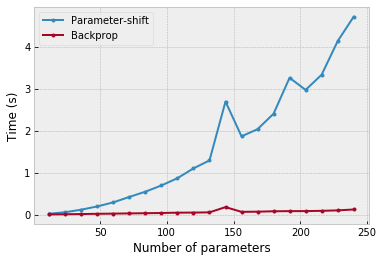

In [20]:
from matplotlib import pyplot as plt
plt.style.use("bmh")

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.plot(*gradient_shift, '.-', label="Parameter-shift")
ax.plot(*gradient_backprop, '.-', label="Backprop")
ax.set_ylabel("Time (s)")
ax.set_xlabel("Number of parameters")
ax.legend()

plt.show()

?????

For a better comparision, we can scale the time required for computing the quantum gradients against the time taken for the corresponding forward pass:


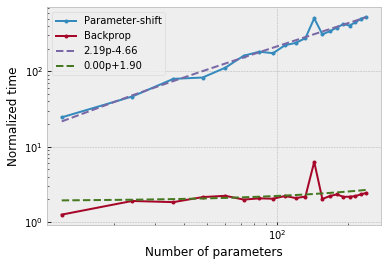

In [21]:
gradient_shift[1] /= forward_shift[1, 1:]
gradient_backprop[1] /= forward_backprop[1, 1:]

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.plot(*gradient_shift, '.-', label="Parameter-shift")
ax.plot(*gradient_backprop, '.-', label="Backprop")

# perform a least squares regression to determine the linear best fit/gradient
# for the normalized time vs. number of parameters
x = gradient_shift[0]
m_shift, c_shift = np.polyfit(*gradient_shift, deg=1)
m_back, c_back = np.polyfit(*gradient_backprop, deg=1)

ax.plot(x, m_shift * x + c_shift, '--', label=f"{m_shift:.2f}p{c_shift:+.2f}")
ax.plot(x, m_back * x + c_back, '--', label=f"{m_back:.2f}p{c_back:+.2f}")

ax.set_ylabel("Normalized time")
ax.set_xlabel("Number of parameters")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()

plt.show()